In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.python.framework import ops

%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]
plt.style.use('ggplot')

In [2]:
!../scripts/copy_data.sh

In [3]:
DATA_PATH = '../data/'

In [4]:
def read(filepath, pred=False):
    dat = pd.read_csv(filepath)
    if not pred:
        dat['buyDate'] = pd.to_datetime(dat['buyDate'])
    return dat

In [5]:
ls -la ../data

total 2392
drwxr-xr-x   6 dsp  staff      204 Jul 13 21:00 ./
drwxr-xr-x  11 dsp  staff      374 Jul  1 16:27 ../
-rw-r--r--@  1 dsp  staff     6148 Jul 13 21:00 .DS_Store
-rw-r--r--@  1 dsp  staff     1749 Sep 10 22:11 Multistock.csv
-rw-r--r--@  1 dsp  staff    34185 Sep 10 22:11 buyStats.csv
-rw-r--r--@  1 dsp  staff  1173859 Sep 10 14:44 sp1950.csv


In [6]:
dat = read(DATA_PATH + 'buyStats.csv')
new_dat = read(DATA_PATH + 'Multistock.csv', pred=True)
dat.head()

,stock,bundles,buyPrice,buyDate,nDays,d30Sell,d30Gains,d60Sell,d60Gains,d90Sell,...,stockMACD,stockPmoB,stockPmoW,spVal,macd,spRSI14,spPmoB75_40_20,spPmoW75_40_20,vix,days
0,adbe,0,131.72,2017-04-21,142,136.43,1.03576,141.21,1.07205,149.07,...,-0.066,NaN,NaN,2349.0,-11.60,NaN,NaN,NaN,14.20,41384
1,jblu,0,21.46,2017-04-21,142,21.18,0.98695,22.74,1.05965,23.33,...,0.250,NaN,NaN,2349.0,-11.60,NaN,NaN,NaN,14.20,41384
2,tsco,0,63.35,2017-04-21,142,57.57,0.90876,55.69,0.87908,51.70,...,-1.254,NaN,NaN,2349.0,-11.60,NaN,NaN,NaN,14.20,41384
3,ftnt,0,40.16,2017-04-25,138,39.94,0.99452,38.29,0.95344,40.45,...,0.504,NaN,NaN,2374.0,-7.14,NaN,NaN,NaN,10.84,41388
4,pac,0,101.15,2017-04-25,138,109.00,1.07761,110.45,1.09194,117.90,...,0.633,NaN,NaN,2374.0,-7.14,NaN,NaN,NaN,10.84,41388


In [7]:
def drop_missing(dfs, y_col):
    X = dfs[0].copy()
    # cols
    drop_cols = [col for col in list(X) if type(col[0]) == np.float and col.isnan().all()]
    X = X.drop(drop_cols, axis=1)
    X2 = dfs[1].drop(drop_cols, axis=1)
    return X.loc[np.isnan(dat[y_col]) == False, :], X2

In [8]:
dat, new_dat = drop_missing([dat, new_dat], 'd30Gains')
dat.head()

,stock,bundles,buyPrice,buyDate,nDays,d30Sell,d30Gains,d60Sell,d60Gains,d90Sell,...,stockMACD,stockPmoB,stockPmoW,spVal,macd,spRSI14,spPmoB75_40_20,spPmoW75_40_20,vix,days
0,adbe,0,131.72,2017-04-21,142,136.43,1.03576,141.21,1.07205,149.07,...,-0.066,NaN,NaN,2349.0,-11.60,NaN,NaN,NaN,14.20,41384
1,jblu,0,21.46,2017-04-21,142,21.18,0.98695,22.74,1.05965,23.33,...,0.250,NaN,NaN,2349.0,-11.60,NaN,NaN,NaN,14.20,41384
2,tsco,0,63.35,2017-04-21,142,57.57,0.90876,55.69,0.87908,51.70,...,-1.254,NaN,NaN,2349.0,-11.60,NaN,NaN,NaN,14.20,41384
3,ftnt,0,40.16,2017-04-25,138,39.94,0.99452,38.29,0.95344,40.45,...,0.504,NaN,NaN,2374.0,-7.14,NaN,NaN,NaN,10.84,41388
4,pac,0,101.15,2017-04-25,138,109.00,1.07761,110.45,1.09194,117.90,...,0.633,NaN,NaN,2374.0,-7.14,NaN,NaN,NaN,10.84,41388


In [9]:
new_dat.head()

,stock,bundles,MF,MFRisk,n_L52,n_H52,pE,pB,revG5,freeCashFlow,...,stockMACD,stockPmoB,stockPmoW,spVal,macd,spRSI14,spPmoB75_40_20,spPmoW75_40_20,vix,days
0,jd,3,now,10,1.760051,0.839967,NaN,89,91,NaN,...,-1.031,1.88,2.61,2461.43,-1.322,52.34,0.35,0.41,12.12,41527
1,masi,3,none,6,1.601711,0.822653,7.0,77,53,92.0,...,-0.123,-0.46,-0.06,2461.43,-1.322,52.34,0.35,0.41,12.12,41527
2,tmus,3,none,9,1.414656,0.910859,60.0,70,92,91.0,...,-0.226,0.16,0.09,2461.43,-1.322,52.34,0.35,0.41,12.12,41527
3,nyt,3,none,12,1.797170,0.945409,80.0,79,20,68.0,...,0.021,1.86,2.09,2461.43,-1.322,52.34,0.35,0.41,12.12,41527
4,ndaq,3,none,10,1.174566,0.956270,99.0,70,37,91.0,...,-0.834,1.08,1.15,2461.43,-1.322,52.34,0.35,0.41,12.12,41527


In [10]:
def split_xy(df, y_col, first_X):
    y = df[y_col]
    start_col = list(df).index(first_X)
    X = df.iloc[:, start_col:]
    return X, y

In [11]:
X, y = split_xy(dat, 'd30Gains', 'MF')
X_new = new_dat.iloc[:, 2:]
stocks = new_dat['stock']
X.head()

,MF,MFRisk,n_L52,n_H52,pE,pB,revG5,freeCashFlow,grossMarQ,opMarQ,...,stockMACD,stockPmoB,stockPmoW,spVal,macd,spRSI14,spPmoB75_40_20,spPmoW75_40_20,vix,days
0,now,9.0,1.4579,0.9980,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.066,NaN,NaN,2349.0,-11.60,NaN,NaN,NaN,14.20,41384
1,now,6.0,1.4539,0.9270,NaN,NaN,NaN,NaN,NaN,NaN,...,0.250,NaN,NaN,2349.0,-11.60,NaN,NaN,NaN,14.20,41384
2,now,10.0,1.0301,0.6531,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.254,NaN,NaN,2349.0,-11.60,NaN,NaN,NaN,14.20,41384
3,now,9.0,1.4004,0.9889,NaN,NaN,NaN,NaN,NaN,NaN,...,0.504,NaN,NaN,2374.0,-7.14,NaN,NaN,NaN,10.84,41388
4,now,10.0,1.3962,0.9354,NaN,NaN,NaN,NaN,NaN,NaN,...,0.633,NaN,NaN,2374.0,-7.14,NaN,NaN,NaN,10.84,41388


In [12]:
#print(list(X) == list(X_new))
[print('Mismatch:', x, xn) for (x, xn) in zip(list(X), list(X_new)) if x != xn]
[(x, xn) for (x, xn) in zip(list(X), list(X_new))]

[('MF', 'MF'),
 ('MFRisk', 'MFRisk'),
 ('n_L52', 'n_L52'),
 ('n_H52', 'n_H52'),
 ('pE', 'pE'),
 ('pB', 'pB'),
 ('revG5', 'revG5'),
 ('freeCashFlow', 'freeCashFlow'),
 ('grossMarQ', 'grossMarQ'),
 ('opMarQ', 'opMarQ'),
 ('roaTTM', 'roaTTM'),
 ('roiQ', 'roiQ'),
 ('roiTTM', 'roiTTM'),
 ('totDEQ', 'totDEQ'),
 ('Fid', 'Fid'),
 ('FidBest', 'FidBest'),
 ('RSI14', 'RSI14'),
 ('stockMACD', 'stockMACD'),
 ('stockPmoB', 'stockPmoB'),
 ('stockPmoW', 'stockPmoW'),
 ('spVal', 'spVal'),
 ('macd', 'macd'),
 ('spRSI14', 'spRSI14'),
 ('spPmoB75_40_20', 'spPmoB75_40_20'),
 ('spPmoW75_40_20', 'spPmoW75_40_20'),
 ('vix', 'vix'),
 ('days', 'days')]

In [13]:
def one_hot(df):
    X = df.copy()
    X[['mfNone', 'mfNow', 'mfStart']] = pd.get_dummies(X['MF'])
    X = X.drop('MF', axis=1)
    return X

In [14]:
#X_new.head()

In [15]:
X = one_hot(X)
X_new = one_hot(X_new)
X.head()

,MFRisk,n_L52,n_H52,pE,pB,revG5,freeCashFlow,grossMarQ,opMarQ,roaTTM,...,spVal,macd,spRSI14,spPmoB75_40_20,spPmoW75_40_20,vix,days,mfNone,mfNow,mfStart
0,9.0,1.4579,0.9980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2349.0,-11.60,NaN,NaN,NaN,14.20,41384,0,1,0
1,6.0,1.4539,0.9270,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2349.0,-11.60,NaN,NaN,NaN,14.20,41384,0,1,0
2,10.0,1.0301,0.6531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2349.0,-11.60,NaN,NaN,NaN,14.20,41384,0,1,0
3,9.0,1.4004,0.9889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2374.0,-7.14,NaN,NaN,NaN,10.84,41388,0,1,0
4,10.0,1.3962,0.9354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2374.0,-7.14,NaN,NaN,NaN,10.84,41388,0,1,0


In [16]:
def median_fill(df):
    X = df.copy()

    for col in list(X):
        try:
            X[col][np.isnan(X[col])] = np.nanmedian(X[col])
        except:
            print('Could not fill column', col)
    return X

In [17]:
X = median_fill(X)
X_new = median_fill(X_new)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/site-packages/numpy/lib/function_base.py:3858: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=11235)
# Reindex
X_train.index = range(len(y_train))
y_train.index = range(len(y_train))

In [19]:
X.head()

,MFRisk,n_L52,n_H52,pE,pB,revG5,freeCashFlow,grossMarQ,opMarQ,roaTTM,...,spVal,macd,spRSI14,spPmoB75_40_20,spPmoW75_40_20,vix,days,mfNone,mfNow,mfStart
0,9.0,1.4579,0.9980,65.0,72.0,68.0,85.0,54.0,75.0,77.0,...,2349.0,-11.60,61.48,0.59,0.59,14.20,41384,0,1,0
1,6.0,1.4539,0.9270,65.0,72.0,68.0,85.0,54.0,75.0,77.0,...,2349.0,-11.60,61.48,0.59,0.59,14.20,41384,0,1,0
2,10.0,1.0301,0.6531,65.0,72.0,68.0,85.0,54.0,75.0,77.0,...,2349.0,-11.60,61.48,0.59,0.59,14.20,41384,0,1,0
3,9.0,1.4004,0.9889,65.0,72.0,68.0,85.0,54.0,75.0,77.0,...,2374.0,-7.14,61.48,0.59,0.59,10.84,41388,0,1,0
4,10.0,1.3962,0.9354,65.0,72.0,68.0,85.0,54.0,75.0,77.0,...,2374.0,-7.14,61.48,0.59,0.59,10.84,41388,0,1,0


In [20]:
print(X_train.shape)
print(X_test.shape)
print(X_new.shape)

#print(list(X) == list(X_new))
[print('Mismatch:', x, xn) for (x, xn) in zip(list(X), list(X_new)) if x != xn]
[(x, xn) for (x, xn) in zip(list(X), list(X_new))]

(99, 29)
(25, 29)
(11, 29)


[('MFRisk', 'MFRisk'),
 ('n_L52', 'n_L52'),
 ('n_H52', 'n_H52'),
 ('pE', 'pE'),
 ('pB', 'pB'),
 ('revG5', 'revG5'),
 ('freeCashFlow', 'freeCashFlow'),
 ('grossMarQ', 'grossMarQ'),
 ('opMarQ', 'opMarQ'),
 ('roaTTM', 'roaTTM'),
 ('roiQ', 'roiQ'),
 ('roiTTM', 'roiTTM'),
 ('totDEQ', 'totDEQ'),
 ('Fid', 'Fid'),
 ('FidBest', 'FidBest'),
 ('RSI14', 'RSI14'),
 ('stockMACD', 'stockMACD'),
 ('stockPmoB', 'stockPmoB'),
 ('stockPmoW', 'stockPmoW'),
 ('spVal', 'spVal'),
 ('macd', 'macd'),
 ('spRSI14', 'spRSI14'),
 ('spPmoB75_40_20', 'spPmoB75_40_20'),
 ('spPmoW75_40_20', 'spPmoW75_40_20'),
 ('vix', 'vix'),
 ('days', 'days'),
 ('mfNone', 'mfNone'),
 ('mfNow', 'mfNow'),
 ('mfStart', 'mfStart')]

In [21]:
# WHILE DATA SET IS SMALL, restrict values in new data to the range seen in training data
for col in list(X_train):
    mn, mx = np.min(X_train[col]), np.max(X_train[col])
    X_new[col][X_new[col] < mn] = mn
    X_new[col][X_new[col] > mx] = mx

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [22]:
for col in list(X_train):
    if np.isnan(X_train[col]).any():
        print(col)

stockPmoB
stockPmoW


In [23]:
X_train['stockPmoB'].unique()

array([ nan])

In [24]:
# While no variation, drop cols
drop_cols = ['stockPmoB', 'stockPmoW']
X_train = X_train.drop(drop_cols, axis=1)
X_test = X_test.drop(drop_cols, axis=1)
X_new = X_new.drop(drop_cols, axis=1)

In [25]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_new  = scaler.transform(X_new)

## Create Neural Net

In [26]:
# Create a fully-connected layer of neurons using dropout regularization
def make_drop_layer(in_layer,
                    n_out,
                    activation,
                    kernel_initializer,
                    dropout_rate,
                    training):
    h = tf.layers.dense(in_layer,
                        n_out,
                        activation=activation,
                        kernel_initializer=kernel_initializer)
    h_drop = tf.layers.dropout(h, rate=dropout_rate, training=training)
    return h_drop

In [59]:
ops.reset_default_graph()
g = tf.get_default_graph()
[op.name for op in g.get_operations()]

[]

In [60]:
N, D = X_train.shape
DROPOUT_RATE = 0
ETA = 0.05 # Learning rate

X = tf.placeholder(tf.float32, shape=[None, D], name='X')
y = tf.placeholder(tf.float32, shape=None, name='y')
training = tf.placeholder_with_default(False, shape=(), name='training')

X_drop = tf.layers.dropout(X, DROPOUT_RATE, training=training)
n_neurons = [D, 27, 27, 25, 27, 23, 20, 1]

In [61]:
with tf.name_scope('dnn'):
    # He intialization randomly initalizes weigths and their variances in 
    # a way that minimizes the likelihood of vanishing/exploding gradients
    he_init = tf.contrib.layers.variance_scaling_initializer()
    current_in = X

    for layer in range(1, len(n_neurons)):
        current_in = make_drop_layer(
            in_layer=current_in,
            n_out=n_neurons[layer],
            activation=tf.nn.tanh if (layer + 1) < len(n_neurons) else None,
            kernel_initializer=he_init,
            dropout_rate=DROPOUT_RATE,
            training=training)

    preds = tf.nn.relu(current_in)

In [62]:
with tf.name_scope('cost'):
    # MSE
    cost = tf.reduce_sum(tf.pow(preds - y, 2))/(2 * N)

In [63]:
with tf.name_scope('train'):
    eta0 = ETA # initial learning rate
    decay_steps = 100  # eta updates after this many epochs
    decay_rate = 0.99    # factor to change eta by
    global_step = tf.Variable(0, trainable=False, name='global_step')
    eta = tf.train.exponential_decay(
        eta0, global_step, decay_steps, decay_rate, name='eta')
    optimizer = tf.train.AdamOptimizer(eta).minimize(
        cost, global_step=global_step)

In [64]:
epochs = 10000
batch_size = 20
train_err = []
test_err = []
saver = tf.train.Saver()

In [65]:
print(X_train.shape)
print(y_train.shape)

(99, 27)
(99,)


In [66]:
with tf.Session() as s:
    s.run(tf.global_variables_initializer())

    for epoch in range(epochs):
        idxs = np.random.permutation(range(N))
        n_batches = len(idxs) // batch_size

        for batch in range(n_batches):
            idx = idxs[batch * batch_size : (batch + 1) * batch_size]
            s.run(optimizer, feed_dict={training: True,
                                        X: X_train[idx, :],
                                        y: y_train[idx]})
        err_train = cost.eval(feed_dict={X: X_train[idx, :],
                                         y: y_train[idx]})
        err_test = cost.eval(feed_dict={X: X_test, y: y_test}) * (N) / (len(y_test))

        train_err.append(err_train)
        test_err.append(err_test)

        if epoch % 100 == 0:
            print(
                '%4d: Train error: %.5f\tTest error: %.9f'
                %(epoch, err_train, err_test))

    save_path = saver.save(s, './nn_mod.ckpt')

   0: Train error: 1.54091	Test error: 9.190305004
 100: Train error: 0.01547	Test error: 0.157985063
 200: Train error: 0.03491	Test error: 0.151747957
 300: Train error: 0.01033	Test error: 0.139408802
 400: Train error: 0.02203	Test error: 0.151955889
 500: Train error: 0.01477	Test error: 0.121252166
 600: Train error: 0.02839	Test error: 0.140422481
 700: Train error: 0.02534	Test error: 0.123093684
 800: Train error: 0.04990	Test error: 0.258254199
 900: Train error: 0.01357	Test error: 0.142673526
1000: Train error: 0.01265	Test error: 0.122564075
1100: Train error: 0.01395	Test error: 0.179832111
1200: Train error: 0.03045	Test error: 0.179324534
1300: Train error: 0.01763	Test error: 0.118979502
1400: Train error: 0.01302	Test error: 0.129106801
1500: Train error: 0.01852	Test error: 0.135266413
1600: Train error: 0.01498	Test error: 0.124717136
1700: Train error: 0.01868	Test error: 0.138877931
1800: Train error: 0.01923	Test error: 0.136407197
1900: Train error: 0.01115	Test

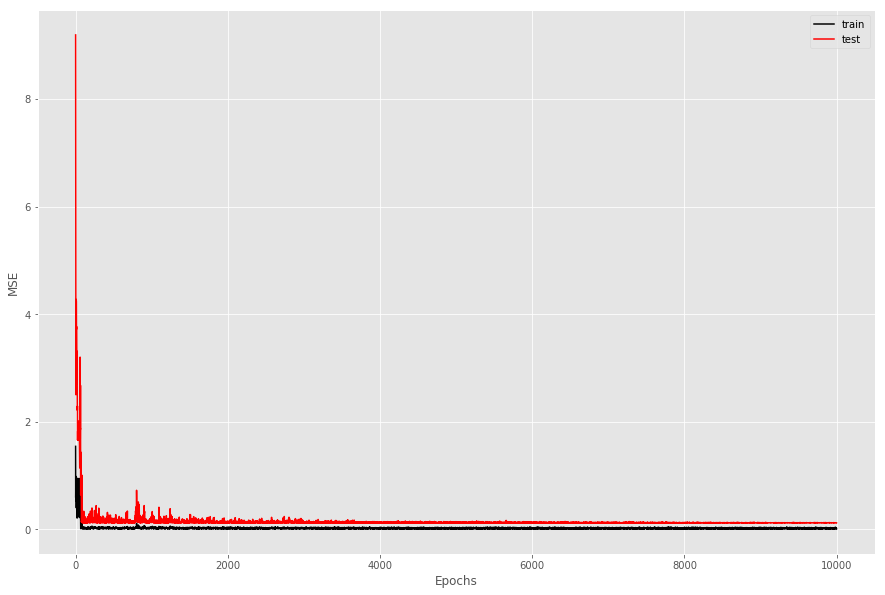

In [67]:
plt.plot(train_err, 'k-', label='train');
plt.plot(test_err, 'r-', label='test');
plt.legend(loc='best');
plt.xlabel('Epochs');
plt.ylabel('MSE');

In [68]:
s = tf.Session()
saver = tf.train.Saver()
saver.restore(s, './nn_mod.ckpt')
new_preds = s.run(preds, feed_dict={X: X_new})
#new_preds = s.run(preds, feed_dict={X: X_test})

In [69]:
final_out = []
for stock, pred in zip(stocks, new_preds.reshape(new_preds.shape[0])):
    final_out.append([stock, pred])
    
out = pd.DataFrame(columns=['Stock', 'Prediction'], data=final_out)
out = out.sort_values('Prediction', ascending=False)
out.head(len(stocks))

,Stock,Prediction
0,jd,1.008759
3,nyt,1.008759
4,ndaq,1.008759
6,fake,1.008759
7,fake,1.008759
8,mtn,1.008759
9,sbux,1.008759
2,tmus,1.008758
10,dis,1.008756
5,mtch,1.007468
